# Right-hand rule for deadlock resolution

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env


import shapely

from panav.ORCA import VO, ORCA_Agent
from panav.SAMP import SA_MILP_Planning
from panav.util import unique_tx

%load_ext autoreload
%autoreload 2

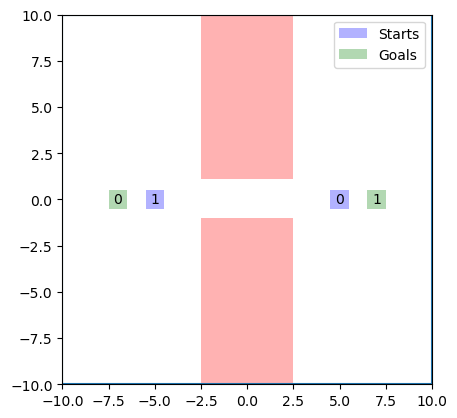

In [8]:

start_locs = np.array([[5,0],[-5,0]])*1.0
goal_locs = np.array([[-7,0],[7,0]])*1.0


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(1.1,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

draw_env(env)

**Compute individual paths that avoid all static obstacles**

In [9]:
agents = set(np.arange(len(start_locs)))

plans = []

bloating_r = 0.5
d = 2
K = 10
t0 = 0
vmax = 1.0

for agent in agents:
    start = env.starts[agent]
    goal = env.goals[agent]

    times, xs = SA_MILP_Planning(env,start,goal,vmax,bloating_r,\
                                 [],\
                                d,K,t0)

    times,xs = unique_tx(times,xs)
    plans.append(xs)

In [10]:


tau = 2 # The safe time interval. Can be generously long.
exec_tau = 0.5 * tau 

detection_radius = bloating_r * 5

# The execution time of ORCA velocity.
# Can be shorter than the safe interval tau.

pos = []
vs = [np.zeros(start_locs[0].shape) for a in agents]
v_prefs = [np.zeros(start_locs[0].shape) for a in agents]

protocol = 0

orcas = [ORCA_Agent(protocol,tau,bloating_r,vmax,np.array(p),v) 
         for p,v in zip(start_locs,vs)]

curr_wp_index = [0 for a in agents]

makespans = np.zeros(len(agents))

curr_time = 0
for _ in range(400):
    pos.append(np.array([a.p for a in orcas]))
    
    # Compute the preferred velocity.
    for agent in agents:
        wp = plans[agent][:,curr_wp_index[agent]]
        to_wp = wp-orcas[agent].p
        
        # See if the agent has reached the current waypoint.
        if np.linalg.norm(to_wp)<= bloating_r:  
            curr_wp_index[agent] = \
            np.min([curr_wp_index[agent]+1,   
                    plans[agent].shape[1]-1
                                  ])

        
        v_prefs[agent] = vmax * to_wp / np.linalg.norm(to_wp)
    
    # Update v_opt
    for a in agents:
        orcas[a].update_v_opt(v_prefs[a])
    
    # Compute the safe velocity.
    for a in agents:    
        
        neighbors = [b for b in agents-{a}
            if np.linalg.norm(orcas[a].p-orcas[b].p)<= detection_radius]
        
        orcas[a].update_v(v_prefs[a],env.obstacles,
                        [orcas[b] for b in neighbors])
    
    # Execute the safe velocity.
    all_reached = True
    curr_time +=exec_tau
    for a in agents:
        if np.linalg.norm(orcas[a].p \
                        - goals[a].project(orcas[a].p))\
                        >=1*bloating_r:
            orcas[a].p += orcas[a].v*exec_tau
            all_reached = False
            makespans[a] = curr_time
    
    
    if all_reached:
        break

Potential deadlock
Potential deadlock


**Visualize the trajectories**

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


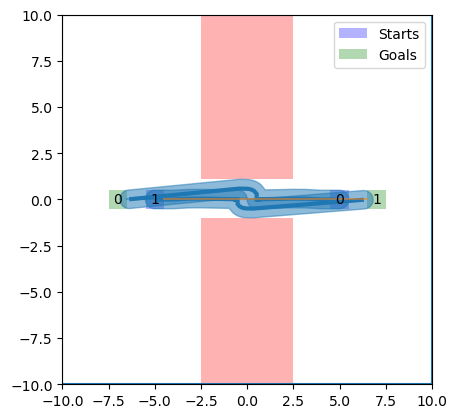

In [11]:

from shapely.plotting import plot_polygon, plot_line
pos = np.array(pos)

ax = plt.gca()
draw_env(env,plans,ax)

for a in agents:
    line = shapely.geometry.LineString(pos[:,a,:])
    dilated = line.buffer(bloating_r)

    plot_line(line, ax=ax, add_points=False, linewidth=3)
    plot_polygon(dilated, ax=ax, add_points=False, alpha=0.5)

**Animate the motions**

In [13]:
from panav.viz import animation
from IPython.display import HTML, display

dt = 0.05

pos_to_ani = [pos[:,a,:].T for a in agents]
anim = animation(env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
anim.save('right_hand_rule_SIMPLE.gif')
plt.close() 

MovieWriter ffmpeg unavailable; using Pillow instead.
